# Goal:

* Determine the sequence coverage for each sample
  * Get an idea of how much more sequencing is needed to reach certain coverage thresholds

In [2]:
biomFile = 'data/otu_table_515SIP_wtax.biom'
metadataFile = 'data/Metadata_515806_Density.txt'
workDir = '/home/chantal/Chazy/Chazy_SIP/'
nprocs = 10

# Init

In [3]:
import os
from IPython.display import FileLink

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(tidyr)
library(iNEXT)
library(vegan)
library(doParallel)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__

In [6]:
%%R -i nprocs
# loading
print(nprocs)

[1] 10


In [7]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Loading/editting OTU table

In [8]:
%%R -i biomFile -i metadataFile

## biom file
physeq = import_biom(biomFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19187 taxa and 637 samples ]
sample_data() Sample Data:       [ 637 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 19187 taxa by 8 taxonomic ranks ]


# Coverage of SIP samples

In [10]:
%%R 
sparcity.thresh = 0.25

# filtering/normalizing
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (sparcity.thresh * length(x)), TRUE)

# filtering to just SIP samples
physeq.thresh.m = physeq.thresh %>% sample_data
physeq.thresh = prune_samples(physeq.thresh.m$Experiment == 'Chazy_SIP_515806', physeq.thresh)    
    
physeq.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 637 samples ]
sample_data() Sample Data:       [ 637 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 8 taxonomic ranks ]


# Plotting total abundance for each sample

In [13]:
%%R
tbl.otu = physeq %>% otu_table %>% as.data.frame
tbl.otu$otu = rownames(tbl.otu)

nc = ncol(tbl.otu)
tbl.otu[1:3,(nc-5):nc]

         13C.NTH.D30.R4.H20 12C.PTH.D7.R4.H2O 12C.NTH.D4.R4.H2O
OTU.17                    1                 0                 0
OTU.900                   0                 0                 0
OTU.1928                  0                 0                 0
         12C.PTH.D3.R4.H2O 12C.NTH.D3.R4.Frac9      otu
OTU.17                   0                   0   OTU.17
OTU.900                  0                   0  OTU.900
OTU.1928                 0                   0 OTU.1928


In [14]:
%%R
# wide to long table
tbl.otu = tbl.otu %>%
    gather('sample','count',1:(nc-1))
tbl.otu %>% head(n=4)

        otu               sample count
1    OTU.17 13X.PTH.D3.R4.Frac12   555
2   OTU.900 13X.PTH.D3.R4.Frac12     3
3  OTU.1928 13X.PTH.D3.R4.Frac12     1
4 OTU.14833 13X.PTH.D3.R4.Frac12    13


In [15]:
%%R

tbl.otu.s = tbl.otu %>%
    group_by(sample) %>%
    summarize(total_count = sum(count))
tbl.otu.s %>% head(n=4)

Source: local data frame [4 x 2]

                sample total_count
                (fctr)       (dbl)
1 13X.PTH.D3.R4.Frac12       26218
2 12C.PTH.D14.R4.Frac6       40897
3  12C.NTH.D1.R4.Frac7       37861
4  12C.NTH.D1.R4.Frac6       31897


In [152]:
%%R
filter(tbl.otu.s, sample %in% tbl.iNEXT.res.d$sample) %>% arrange(desc(total_count))

Source: local data frame [113 x 2]

                  sample total_count
                  (fctr)       (dbl)
1  12C.NTH.D30.R4.Frac12        6155
2  13X.PTH.D14.R4.Frac28        6046
3  13X.NTH.D14.R4.Frac26        6026
4  13C.PTH.D30.R4.Frac26        5652
5    12C.NTH.D7.R4.Frac6        5497
6   12C.NTH.D30.R4.Frac8        5453
7    13X.NTH.D7.R4.Frac5        5388
8  13C.PTH.D30.R4.Frac22        5245
9  13C.PTH.D30.R4.Frac14        5228
10 12C.NTH.D30.R4.Frac10        5068
..                   ...         ...


In [161]:
%%R
sam = filter(sample.data, Pool == "2")

In [169]:
%%R
filter(tbl.otu.s, sample %in% sam$Full.sample) %>% arrange(desc(total_count))

Source: local data frame [192 x 2]

                  sample total_count
                  (fctr)       (dbl)
1   12C.NTH.D30.R4.Frac5       12085
2   12C.NTH.D30.R4.Frac9        9118
3  12C.NTH.D30.R4.Frac13        8978
4   13C.PTH.D30.R4.Frac6        8435
5   13X.PTH.D1.R4.Frac15        8360
6   12C.NTH.D30.R4.Frac4        7576
7   13X.NTH.D7.R4.Frac14        7405
8   13X.PTH.D14.R4.Frac8        7300
9    13X.NTH.D7.R4.Frac6        7257
10 13X.NTH.D14.R4.Frac28        7238
..                   ...         ...


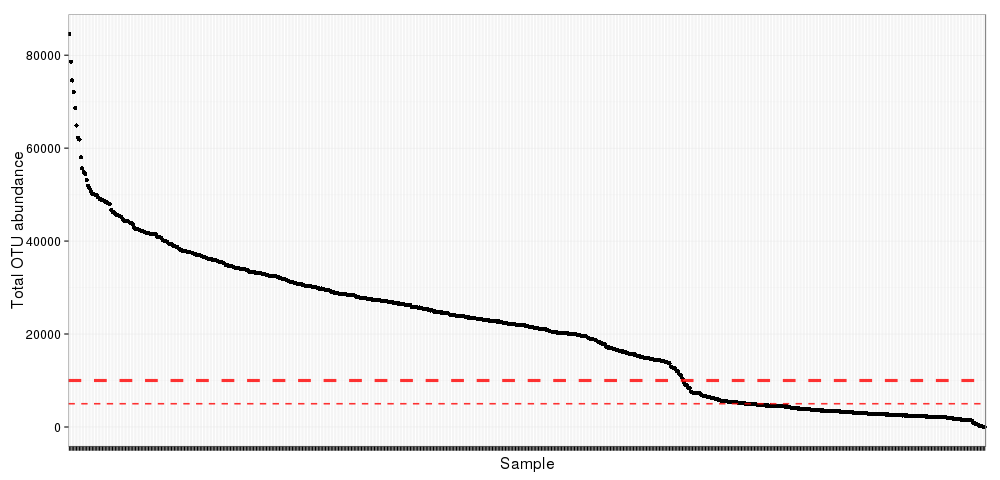

In [16]:
%%R -w 1000 
# sample rank abundance
tbl.otu.s$sample = reorder(tbl.otu.s$sample, -tbl.otu.s$total_count)

ggplot(tbl.otu.s, aes(sample, total_count)) +
    geom_point() +
    geom_hline(yintercept=10000, alpha=0.8, linetype='dashed', size=1.5, color='red') +
    geom_hline(yintercept=5000, alpha=0.8, linetype='dashed', size=0.75, color='red') +
    labs(x = 'Sample', y = 'Total OTU abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

#### Notes

* small dashed line = 5000 sequences
* large dashed line = 10000 sequences

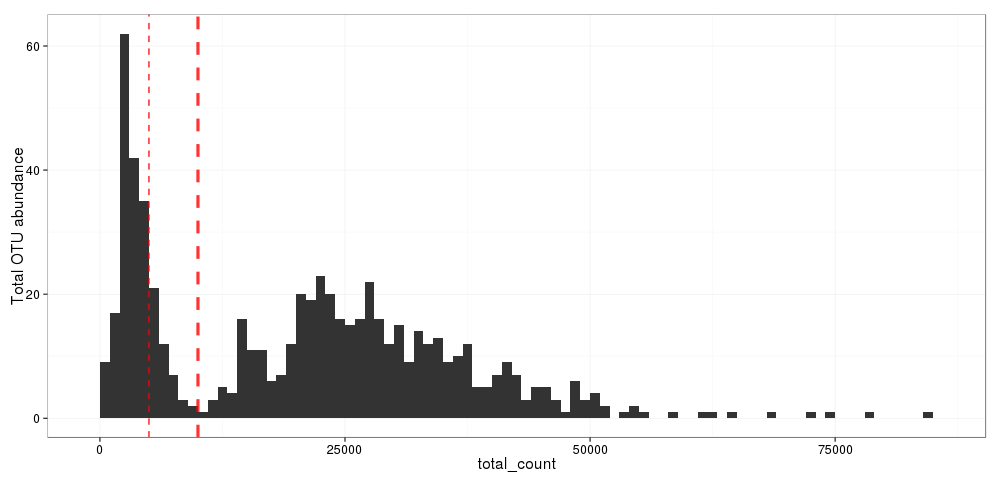

In [17]:
%%R -w 1000 
# sample rank abundance
tbl.otu.s$sample = reorder(tbl.otu.s$sample, -tbl.otu.s$total_count)

ggplot(tbl.otu.s, aes(total_count)) +
    geom_histogram(binwidth=1000) +
    geom_vline(xintercept=10000, alpha=0.8, linetype='dashed', size=1.5, color='red') +
    geom_vline(xintercept=5000, alpha=0.8, linetype='dashed', size=0.75, color='red') +
    labs(y = 'Total OTU abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Estimating coverage for each sample

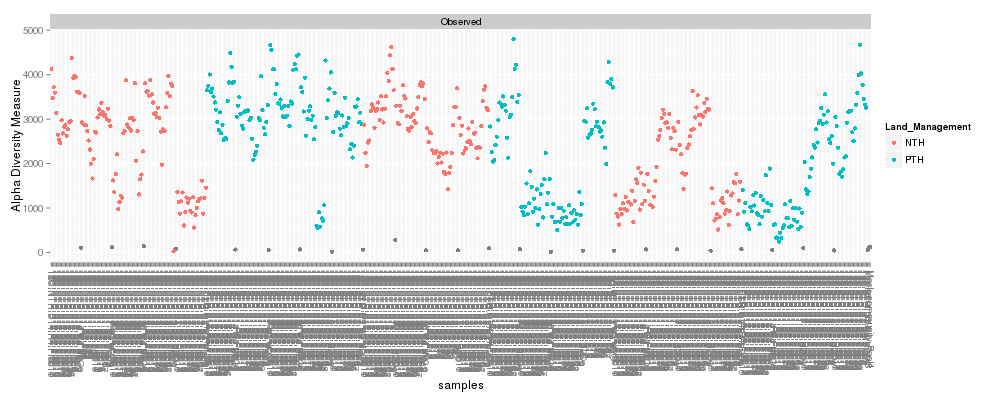

In [20]:
%%R -w 1000 -h 400

plot_richness(physeq, measures=c('Observed'), color='Land_Management')

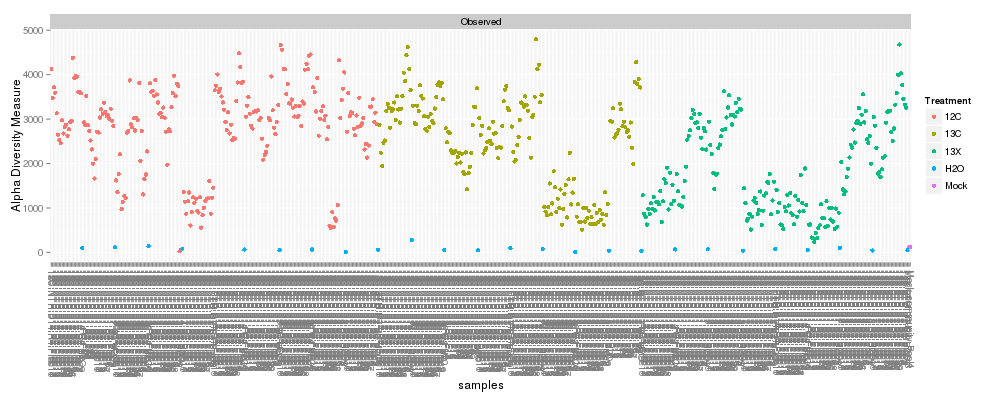

In [23]:
%%R -w 1000 -h 400

plot_richness(physeq, measures=c('Observed'), color='Treatment')

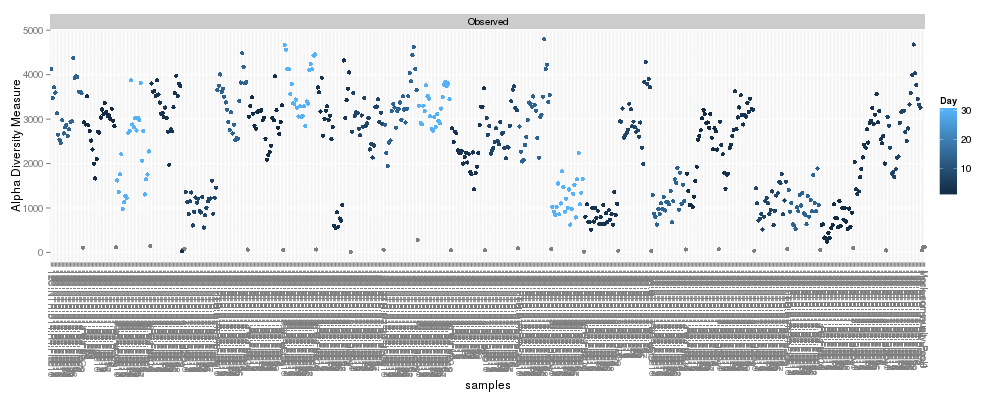

In [31]:
%%R -w 1000 -h 400

plot_richness(physeq, measures=c('Observed'), color=('Day'))

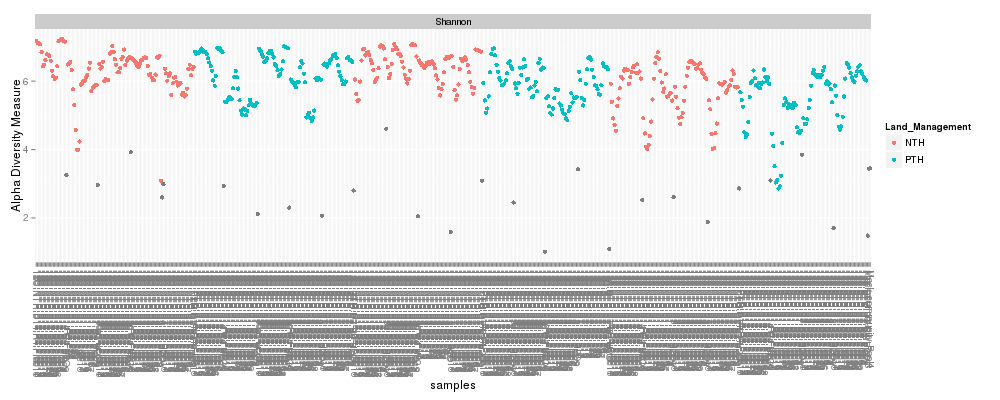

In [22]:
%%R -w 1000 -h 400

plot_richness(physeq, measures=c('Shannon'), color='Land_Management')

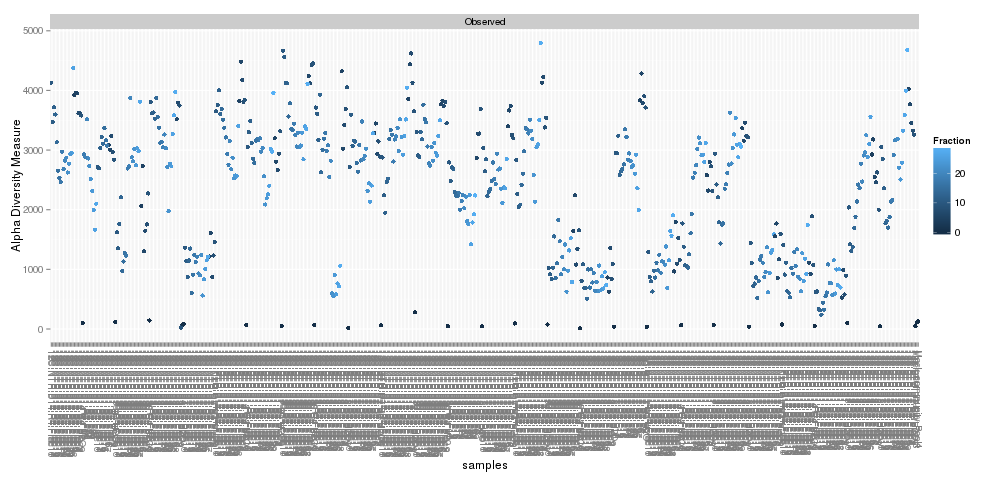

In [26]:
%%R -w 1000 

plot_richness(physeq, measures=c('Observed'), color='Fraction')

#### Notes:

* H2O controls (fraction = 0) are very low in richness.
* It appears that the mock communities also have low richness.

# Calculating Hill Number coverage estimates with iNEXT

In [35]:
%%R 
sparcity.thresh = 0.25

# filtering/normalizing
physeq.thresh = filter_taxa(physeq, function(x) sum(x > 0) > (sparcity.thresh * length(x)), TRUE)

# filtering to just SIP samples
physeq.thresh.m = physeq.thresh %>% sample_data
physeq.thresh = prune_samples(physeq.thresh.m$Experiment == 'Chazy_SIP_515806', physeq.thresh)    
    
physeq.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 637 samples ]
sample_data() Sample Data:       [ 637 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 8 taxonomic ranks ]


In [36]:
%%R -i workDir
# saving data structure
outTmp = paste(c(workDir, 'physeq_thresh'), collapse='/')
saveRDS(physeq.thresh, outTmp)

### iNEXT in parallel

In [37]:
!cd $workDir; \
    /home/nick/notebook/fullCyc/bin/iNEXT_parallel.r \
    -p physeq_thresh -q 1 -n 10 -o iNEXT_q1_res

Phyloseq object: loaded
OTU table: parsed
Number of chunks: 318
^C




















Execution halted



### Loading iNEXT results

In [9]:
%%R -i workDir
# loading iNEXT results file
inFile = paste(c(workDir, 'iNEXT_q1_res'), collapse='/')
iNEXT.res.l = readRDS(inFile)

In [10]:
%%R
# combining output
tbl.iNEXT.res = do.call('rbind', lapply(iNEXT.res.l, function(x) do.call('rbind', x$iNextEst)))
#tbl.iNEXT.res %>% head(n=4)

# editing table
#tbl.iNEXT.res$sample = gsub('[0-9]+C-[0-9]+\\.(.+)\\.[0-9]+$', '\\1', rownames(tbl.iNEXT.res))
tbl.iNEXT.res$sample = gsub('\\.[0-9]+$', '', rownames(tbl.iNEXT.res))
tbl.iNEXT.res$RF = gsub('[0-9]+C-.+\\.(.+)$', '\\1', tbl.iNEXT.res$sample)
tbl.iNEXT.res$RF = gsub('Mock_.+F(.+)\\.[0-9]+$', 'R1_F\\1', tbl.iNEXT.res$RF)
tbl.iNEXT.res$fraction = gsub('.+\\Frac(-*[0-9]+)$', '\\1', tbl.iNEXT.res$RF) %>% as.numeric
tbl.iNEXT.res$microcosm = gsub('(.+)\\Frac-*[0-9]+$', '\\1', tbl.iNEXT.res$RF)
tbl.iNEXT.res = tbl.iNEXT.res %>%
    separate(microcosm, c('treatment', 'tillage', 'day', 'microcosm_rep'), sep='\\.') %>%
    mutate(day = gsub('D','',day) %>% as.numeric,
           fraction = fraction %>% as.numeric,
           microcosm_rep = gsub('R', '', microcosm_rep),
           mock_cont = ifelse(fraction < 0, TRUE, FALSE),
           water_cont = ifelse(fraction == "H2O", TRUE, FALSE),
           control = ifelse(fraction == "H2O", TRUE, FALSE))

tbl.iNEXT.res %>% head(n=4)

     m       method order     qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1    1 interpolated     1  1.000     1.000     1.000 0.040     0.039     0.042
2 1410 interpolated     1 79.190    76.932    81.448 0.893     0.891     0.896
3 2820 interpolated     1 86.911    84.329    89.494 0.932     0.930     0.934
4 4230 interpolated     1 90.449    87.716    93.181 0.948     0.946     0.949
                sample                   RF fraction treatment tillage day
1 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
2 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
3 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
4 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
  microcosm_rep mock_cont water_cont control
1             4     FALSE      FALSE   FALSE
2             4     FALSE      FALSE   FALSE
3             4     FALSE      FALSE   FALSE
4             4     FALSE      FALSE   FALSE


In [11]:
%%R
# adding observed values to each
obs = tbl.iNEXT.res %>% 
    filter(method == 'observed') %>%
    select(sample, order, 'm.obs' = m)

tbl.iNEXT.res.j = inner_join(tbl.iNEXT.res, obs, c('sample' = 'sample',
                                                   'order' = 'order'))

tbl.iNEXT.res.j %>% head(n=4)

     m       method order     qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1    1 interpolated     1  1.000     1.000     1.000 0.040     0.039     0.042
2 1410 interpolated     1 79.190    76.932    81.448 0.893     0.891     0.896
3 2820 interpolated     1 86.911    84.329    89.494 0.932     0.930     0.934
4 4230 interpolated     1 90.449    87.716    93.181 0.948     0.946     0.949
                sample                   RF fraction treatment tillage day
1 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
2 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
3 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
4 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
  microcosm_rep mock_cont water_cont control m.obs
1             4     FALSE      FALSE   FALSE 25376
2             4     FALSE      FALSE   FALSE 25376
3             4     FALSE      FALSE   FALSE 25376
4             4     FALSE 

### Sampling depth for 90% coverage

In [12]:
%%R
# for each sample: first m where sequence coverage is > 80% 
tbl.iNEXT.res.fm = tbl.iNEXT.res.j %>% 
    filter(SC >= 0.90) %>%
    group_by(order, sample) %>%
    mutate(first.m = first(m)) %>%
    filter(m == first.m)
tbl.iNEXT.res.fm %>% head(n=5) %>% as.data.frame

     m       method order      qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1 2820 interpolated     1  86.911    84.329    89.494 0.932     0.930     0.934
2 8155 interpolated     1 597.319   584.545   610.093 0.918     0.917     0.919
3 5828 interpolated     1 218.838   214.888   222.787 0.906     0.905     0.908
4 6552 interpolated     1 218.628   213.395   223.861 0.913     0.911     0.915
5 7111 interpolated     1 301.711   294.851   308.572 0.912     0.910     0.915
                sample                   RF fraction treatment tillage day
1 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
2 12C.PTH.D14.R4.Frac6 12C.PTH.D14.R4.Frac6        6       12C     PTH  14
3  12C.NTH.D1.R4.Frac7  12C.NTH.D1.R4.Frac7        7       12C     NTH   1
4  12C.NTH.D1.R4.Frac6  12C.NTH.D1.R4.Frac6        6       12C     NTH   1
5 12C.NTH.D1.R4.Frac14 12C.NTH.D1.R4.Frac14       14       12C     NTH   1
  microcosm_rep mock_cont water_cont control m.obs first.m
1          

In [25]:
%%R
not90 = (tbl.iNEXT.res.j) %>% group_by(sample) %>% summarise(maxSC = max(SC), m = max(m), m.obs = max(m.obs)) %>% filter(maxSC <0.90)

In [19]:
%%R
filter(sample.data, Full.sample %in% not90$sample) %>%
select(Full.sample, Barcode, Pool)

             Full.sample Barcode Pool
1    12C.NTH.D3.R4.Frac9     155    1
2   13X.PTH.D14.R4.Frac7      10    2
3  13X.PTH.D14.R4.Frac21      24    2
4  13X.PTH.D14.R4.Frac23      26    2
5  13X.PTH.D14.R4.Frac25      28    2
6    13C.PTH.D3.R4.Frac6      34    2
7   13C.PTH.D3.R4.Frac10      38    2
8   13C.PTH.D3.R4.Frac12      40    2
9   13C.PTH.D3.R4.Frac16      44    2
10  13C.PTH.D3.R4.Frac20      48    2
11  13C.PTH.D3.R4.Frac22      50    2
12  13C.PTH.D3.R4.Frac28      56    2
13  13X.PTH.D1.R4.Frac22      74    2
14  13X.PTH.D1.R4.Frac24      76    2
15  13X.NTH.D14.R4.Frac5      82    2
16 13X.NTH.D14.R4.Frac11      88    2
17 13X.NTH.D14.R4.Frac24     101    2
18  13C.PTH.D30.R4.Frac7     109    2
19 13C.PTH.D30.R4.Frac15     117    2
20 13C.PTH.D30.R4.Frac19     121    2
21 13C.PTH.D30.R4.Frac27     129    2
22   12C.NTH.D7.R4.Frac7     133    2
23  12C.NTH.D7.R4.Frac12     138    2
24  12C.NTH.D7.R4.Frac15     141    2
25  12C.NTH.D7.R4.Frac16     142    2
26  12C.NTH.

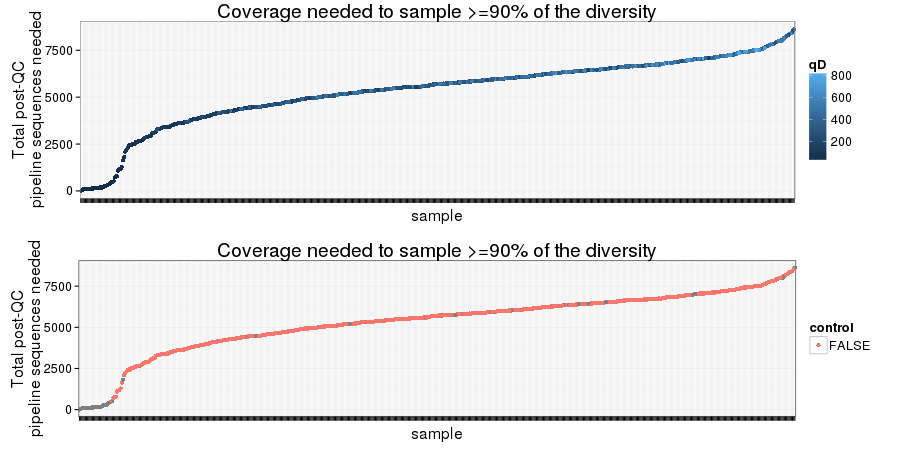

In [27]:
%%R -w 900 -h 450

tbl.iNEXT.res.fm$sample = reorder(tbl.iNEXT.res.fm$sample, tbl.iNEXT.res.fm$first.m)

tbl.iNEXT.res.fm.f = tbl.iNEXT.res.fm %>%
    filter(order == 1)

# plotting 
p1 = ggplot(tbl.iNEXT.res.fm.f, aes(sample, first.m, color=qD)) +
    geom_point() +
    labs(y = 'Total post-QC\npipeline sequences needed',
         title = 'Coverage needed to sample >=90% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank(),
        plot.margin = unit(c(0, 1.2, 0, 0.3), 'cm')
        )

p2 = ggplot(tbl.iNEXT.res.fm.f, aes(sample, first.m, color=control)) +
    geom_point() +
    labs(y = 'Total post-QC\npipeline sequences needed',
         title = 'Coverage needed to sample >=90% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

grid.arrange(p1, p2, ncol=1)

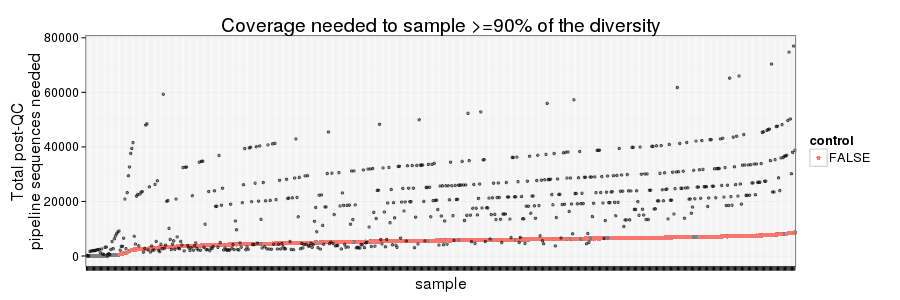

In [28]:
%%R -w 900 -h 300


ggplot(tbl.iNEXT.res.fm.f, aes(sample, first.m, color=control)) +
    geom_point() +
    geom_point(aes(y=m.obs), shape=20, color='black', alpha=0.5) +
    labs(y = 'Total post-QC\npipeline sequences needed',
         title = 'Coverage needed to sample >=90% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

#### Notes

* black circles = number of observed OTUs

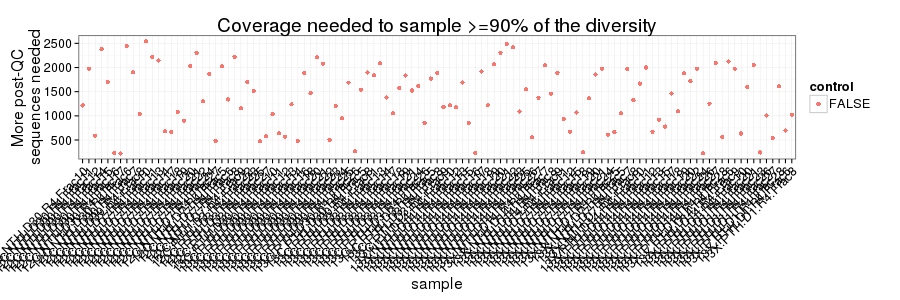

In [29]:
%%R -w 900 -h 300



tbl.iNEXT.res.d = tbl.iNEXT.res.fm %>%
    mutate(extra_needed = ifelse(first.m - m.obs > 0, first.m - m.obs, 0)) %>%#, 
           #microcosm_rep = ifelse(is.na(microcosm_rep), 4, microcosm_rep))# %>%
    filter(extra_needed > 0)

tbl.iNEXT.res.d$sample = reorder(as.character(tbl.iNEXT.res.d$sample), as.character(-tbl.iNEXT.res.d$extra_needed))

ggplot(tbl.iNEXT.res.d, aes(sample, extra_needed, color=control)) +
    geom_point() +
    labs(y = 'More post-QC\nsequences needed',
         title = 'Coverage needed to sample >=90% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
       )

In [30]:
%%R
select(tbl.iNEXT.res.fm, first.m, m.obs, microcosm_rep)

Source: local data frame [610 x 5]
Groups: order, sample [610]

   order                sample first.m m.obs microcosm_rep
   (dbl)                (fctr)   (dbl) (dbl)         (chr)
1      1  13X.PTH.D3.R4.Frac12    2820 25376             4
2      1  12C.PTH.D14.R4.Frac6    8155 36695             4
3      1   12C.NTH.D1.R4.Frac7    5828 34964             4
4      1   12C.NTH.D1.R4.Frac6    6552 29482             4
5      1  12C.NTH.D1.R4.Frac14    7111 25599             4
6      1   13X.NTH.D1.R4.Frac6    4720 21241             4
7      1  12C.NTH.D1.R4.Frac12    6233 28047             4
8      1   12C.NTH.D1.R4.Frac5    6343 38058             4
9      1 13C.NTH.D30.R4.Frac14    5893 17679             4
10     1  13X.NTH.D1.R4.Frac13    1636 29440             4
..   ...                   ...     ...   ...           ...


In [31]:
%%R
cat('Number of samples where more coverage is needed: ',
     tbl.iNEXT.res.d$sample %>% as.vector %>% unique %>% length, '\n')

Number of samples where more coverage is needed:  113 


In [32]:
%%R
cat('#Samples_to_resequence\n')
paste(tbl.iNEXT.res.d$sample %>% as.vector %>% sort, collapse='\n') %>% cat

#Samples_to_resequence
12C.NTH.D30.R4.Frac10
12C.NTH.D30.R4.Frac11
12C.NTH.D30.R4.Frac12
12C.NTH.D30.R4.Frac14
12C.NTH.D30.R4.Frac15
12C.NTH.D30.R4.Frac16
12C.NTH.D30.R4.Frac17
12C.NTH.D30.R4.Frac6
12C.NTH.D30.R4.Frac7
12C.NTH.D30.R4.Frac8
12C.NTH.D7.R4.Frac10
12C.NTH.D7.R4.Frac11
12C.NTH.D7.R4.Frac13
12C.NTH.D7.R4.Frac14
12C.NTH.D7.R4.Frac17
12C.NTH.D7.R4.Frac18
12C.NTH.D7.R4.Frac19
12C.NTH.D7.R4.Frac20
12C.NTH.D7.R4.Frac21
12C.NTH.D7.R4.Frac22
12C.NTH.D7.R4.Frac24
12C.NTH.D7.R4.Frac27
12C.NTH.D7.R4.Frac5
12C.NTH.D7.R4.Frac6
12C.NTH.D7.R4.Frac8
12C.NTH.D7.R4.Frac9
12C.PTH.D3.R4.Frac22
12C.PTH.D3.R4.Frac23
12C.PTH.D3.R4.Frac25
12C.PTH.D3.R4.Frac27
13C.PTH.D30.R4.Frac10
13C.PTH.D30.R4.Frac11
13C.PTH.D30.R4.Frac12
13C.PTH.D30.R4.Frac13
13C.PTH.D30.R4.Frac14
13C.PTH.D30.R4.Frac16
13C.PTH.D30.R4.Frac18
13C.PTH.D30.R4.Frac20
13C.PTH.D30.R4.Frac21
13C.PTH.D30.R4.Frac22
13C.PTH.D30.R4.Frac23
13C.PTH.D30.R4.Frac24
13C.PTH.D30.R4.Frac25
13C.PTH.D30.R4.Frac26
13C.PTH.D30.R4.Frac5
13C.PTH.D30.R4.

In [34]:
%%R
filter(sample.data, Full.sample %in% tbl.iNEXT.res.d$sample) %>%
select(Full.sample, Barcode, Pool)

              Full.sample Barcode Pool
1    12C.PTH.D3.R4.Frac22       1    2
2    12C.PTH.D3.R4.Frac23       2    2
3    12C.PTH.D3.R4.Frac25       4    2
4    12C.PTH.D3.R4.Frac27       6    2
5    13X.PTH.D14.R4.Frac6       9    2
6    13X.PTH.D14.R4.Frac9      12    2
7   13X.PTH.D14.R4.Frac10      13    2
8   13X.PTH.D14.R4.Frac11      14    2
9   13X.PTH.D14.R4.Frac12      15    2
10  13X.PTH.D14.R4.Frac13      16    2
11  13X.PTH.D14.R4.Frac15      18    2
12  13X.PTH.D14.R4.Frac17      20    2
13  13X.PTH.D14.R4.Frac18      21    2
14  13X.PTH.D14.R4.Frac19      22    2
15  13X.PTH.D14.R4.Frac20      23    2
16  13X.PTH.D14.R4.Frac22      25    2
17  13X.PTH.D14.R4.Frac24      27    2
18  13X.PTH.D14.R4.Frac26      29    2
19  13X.PTH.D14.R4.Frac27      30    2
20  13X.PTH.D14.R4.Frac28      31    2
21    13C.PTH.D3.R4.Frac5      33    2
22    13C.PTH.D3.R4.Frac8      36    2
23    13C.PTH.D3.R4.Frac9      37    2
24   13C.PTH.D3.R4.Frac11      39    2
25   13C.PTH.D3.R4.Frac13

In [247]:
%%R
com_sam = c(a, test2$sample)

In [246]:
%%R
a = as.character(tbl.iNEXT.res.d$sample)

In [248]:
%%R
com_sam

  [1] "12C.NTH.D7.R4.Frac9"   "12C.NTH.D30.R4.Frac16" "13X.PTH.D14.R4.Frac24"
  [4] "13X.NTH.D7.R4.Frac8"   "12C.NTH.D30.R4.Frac8"  "12C.NTH.D7.R4.Frac5"  
  [7] "13C.PTH.D30.R4.Frac25" "13X.NTH.D14.R4.Frac7"  "12C.NTH.D30.R4.Frac6" 
 [10] "13X.NTH.D7.R4.Frac18"  "13X.NTH.D14.R4.Frac16" "13C.PTH.D30.R4.Frac20"
 [13] "13X.PTH.D14.R4.Frac18" "12C.NTH.D30.R4.Frac14" "12C.NTH.D7.R4.Frac14" 
 [16] "13X.NTH.D14.R4.Frac25" "12C.PTH.D3.R4.Frac27"  "13X.PTH.D14.R4.Frac9" 
 [19] "13X.PTH.D14.R4.Frac27" "13X.NTH.D14.R4.Frac27" "13X.NTH.D7.R4.Frac25" 
 [22] "13C.PTH.D30.R4.Frac23" "13C.PTH.D3.R4.Frac8"   "13X.PTH.D14.R4.Frac22"
 [25] "13X.PTH.D1.R4.Frac26"  "12C.NTH.D7.R4.Frac6"   "12C.NTH.D7.R4.Frac22" 
 [28] "13C.PTH.D30.R4.Frac22" "13C.PTH.D30.R4.Frac24" "12C.PTH.D3.R4.Frac25" 
 [31] "13X.NTH.D14.R4.Frac23" "13X.NTH.D7.R4.Frac5"   "13C.PTH.D30.R4.Frac26"
 [34] "13C.PTH.D3.R4.Frac13"  "13X.PTH.D14.R4.Frac26" "12C.NTH.D30.R4.Frac11"
 [37] "12C.NTH.D30.R4.Frac7"  "13C.PTH.D30.R4.Frac10" "13X.NTH.D

In [132]:
%%R
head(sample.data)

Sample Data:        [6 samples by 16 sample variables]:
                                Full.sample Fraction PrimerF PrimerR Barcode
12C.PTH.D30.R4.Frac6   12C.PTH.D30.R4.Frac6        6    515f    806r       1
12C.PTH.D30.R4.Frac7   12C.PTH.D30.R4.Frac7        7    515f    806r       2
12C.PTH.D30.R4.Frac8   12C.PTH.D30.R4.Frac8        8    515f    806r       3
12C.PTH.D30.R4.Frac9   12C.PTH.D30.R4.Frac9        9    515f    806r       4
12C.PTH.D30.R4.Frac10 12C.PTH.D30.R4.Frac10       10    515f    806r       5
12C.PTH.D30.R4.Frac11 12C.PTH.D30.R4.Frac11       11    515f    806r       6
                      Rev.index Fwd.index Treatment Day Microcosm.replicate
12C.PTH.D30.R4.Frac6   cgagagtt  atcgtacg       12C  30                   4
12C.PTH.D30.R4.Frac7   cgagagtt  actatctg       12C  30                   4
12C.PTH.D30.R4.Frac8   cgagagtt  tagcgagt       12C  30                   4
12C.PTH.D30.R4.Frac9   cgagagtt  ctgcgtgt       12C  30                   4
12C.PTH.D30.R4.Frac10  cg

## 95% coverage

In [171]:
%%R
# for each sample: first m where sequence coverage is > 80% 
tbl.iNEXT.res.fm = tbl.iNEXT.res.j %>% 
    filter(SC >= 0.95) %>%
    group_by(order, sample) %>%
    mutate(first.m = first(m)) %>%
    filter(m == first.m)
tbl.iNEXT.res.fm %>% head(n=5) %>% as.data.frame

      m       method order      qD qD.95.LCL qD.95.UCL    SC SC.95.LCL
1  5639 interpolated     1  92.562    89.741    95.383 0.957     0.955
2 14270 interpolated     1 640.298   626.508   654.087 0.956     0.955
3 13597 interpolated     1 240.848   236.413   245.284 0.955     0.954
4 13103 interpolated     1 236.014   230.270   241.759 0.953     0.952
5 12799 interpolated     1 323.614   316.069   331.160 0.950     0.948
  SC.95.UCL               sample                   RF fraction treatment
1     0.958 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X
2     0.957 12C.PTH.D14.R4.Frac6 12C.PTH.D14.R4.Frac6        6       12C
3     0.956  12C.NTH.D1.R4.Frac7  12C.NTH.D1.R4.Frac7        7       12C
4     0.954  12C.NTH.D1.R4.Frac6  12C.NTH.D1.R4.Frac6        6       12C
5     0.952 12C.NTH.D1.R4.Frac14 12C.NTH.D1.R4.Frac14       14       12C
  tillage day microcosm_rep mock_cont water_cont control m.obs first.m
1     PTH   3             4     FALSE      FALSE   FALSE 25376   

In [187]:
%%R
head(tbl.iNEXT.res.j)

     m       method order     qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1    1 interpolated     1  1.000     1.000     1.000 0.040     0.039     0.042
2 1410 interpolated     1 79.190    76.932    81.448 0.893     0.891     0.896
3 2820 interpolated     1 86.911    84.329    89.494 0.932     0.930     0.934
4 4230 interpolated     1 90.449    87.716    93.181 0.948     0.946     0.949
5 5639 interpolated     1 92.562    89.741    95.383 0.957     0.955     0.958
6 7049 interpolated     1 93.998    91.117    96.878 0.963     0.962     0.964
                sample                   RF fraction treatment tillage day
1 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
2 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
3 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
4 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH   3
5 13X.PTH.D3.R4.Frac12 13X.PTH.D3.R4.Frac12       12       13X     PTH  

In [194]:
%%R
test= tbl.iNEXT.res.j %>%  group_by(sample) %>% summarise(maxcutoff = max(SC)) %>% arrange(maxcutoff) 
        

In [214]:
%%R
test2 = filter(test, maxcutoff < 0.90) %>% arrange((maxcutoff))

In [222]:
%%R
a = filter(tbl.iNEXT.res.j, sample %in% test2$sample) %>%  group_by(sample) %>% summarise(maxm = max(m), maxobs = max(m.obs), maxcutoff = max(SC))

In [225]:
%%R
a

Source: local data frame [27 x 4]

                  sample  maxm maxobs maxcutoff
                   (chr) (dbl)  (dbl)     (dbl)
1    12C.NTH.D3.R4.Frac9    56     28     0.255
2   12C.NTH.D7.R4.Frac12  4196   2098     0.893
3   12C.NTH.D7.R4.Frac15  2908   1454     0.877
4   12C.NTH.D7.R4.Frac16  4816   2408     0.899
5   12C.NTH.D7.R4.Frac23  2582   1291     0.867
6    12C.NTH.D7.R4.Frac7  3980   1990     0.882
7  13C.PTH.D30.R4.Frac15  3390   1695     0.890
8  13C.PTH.D30.R4.Frac19  4012   2006     0.896
9  13C.PTH.D30.R4.Frac27  3504   1752     0.895
10  13C.PTH.D30.R4.Frac7  4302   2151     0.876
..                   ...   ...    ...       ...


In [211]:
%%R
filter(sample.data, Full.sample %in% test2$sample) %>% select(Full.sample, Barcode, Pool)

             Full.sample Barcode Pool
1    12C.NTH.D3.R4.Frac9     155    1
2   13X.PTH.D14.R4.Frac7      10    2
3  13X.PTH.D14.R4.Frac21      24    2
4  13X.PTH.D14.R4.Frac23      26    2
5  13X.PTH.D14.R4.Frac25      28    2
6    13C.PTH.D3.R4.Frac6      34    2
7   13C.PTH.D3.R4.Frac10      38    2
8   13C.PTH.D3.R4.Frac12      40    2
9   13C.PTH.D3.R4.Frac16      44    2
10  13C.PTH.D3.R4.Frac20      48    2
11  13C.PTH.D3.R4.Frac22      50    2
12  13C.PTH.D3.R4.Frac28      56    2
13  13X.PTH.D1.R4.Frac22      74    2
14  13X.PTH.D1.R4.Frac24      76    2
15  13X.NTH.D14.R4.Frac5      82    2
16 13X.NTH.D14.R4.Frac11      88    2
17 13X.NTH.D14.R4.Frac24     101    2
18  13C.PTH.D30.R4.Frac7     109    2
19 13C.PTH.D30.R4.Frac15     117    2
20 13C.PTH.D30.R4.Frac19     121    2
21 13C.PTH.D30.R4.Frac27     129    2
22   12C.NTH.D7.R4.Frac7     133    2
23  12C.NTH.D7.R4.Frac12     138    2
24  12C.NTH.D7.R4.Frac15     141    2
25  12C.NTH.D7.R4.Frac16     142    2
26  12C.NTH.

In [202]:
%%R
filter(test, maxcutoff < 0.94) %>% arrange(desc(maxcutoff))

Source: local data frame [98 x 2]

                  sample maxcutoff
                   (chr)     (dbl)
1   12C.PTH.D3.R4.Frac25     0.939
2   12C.PTH.D3.R4.Frac27     0.939
3  13C.PTH.D30.R4.Frac24     0.939
4   13X.NTH.D7.R4.Frac12     0.939
5  13X.PTH.D14.R4.Frac10     0.939
6   12C.NTH.D7.R4.Frac22     0.938
7  13C.PTH.D30.R4.Frac10     0.938
8   12C.NTH.D30.R4.Frac7     0.937
9    13X.PTH.D1.R4.Frac6     0.936
10 13X.NTH.D14.R4.Frac12     0.935
..                   ...       ...


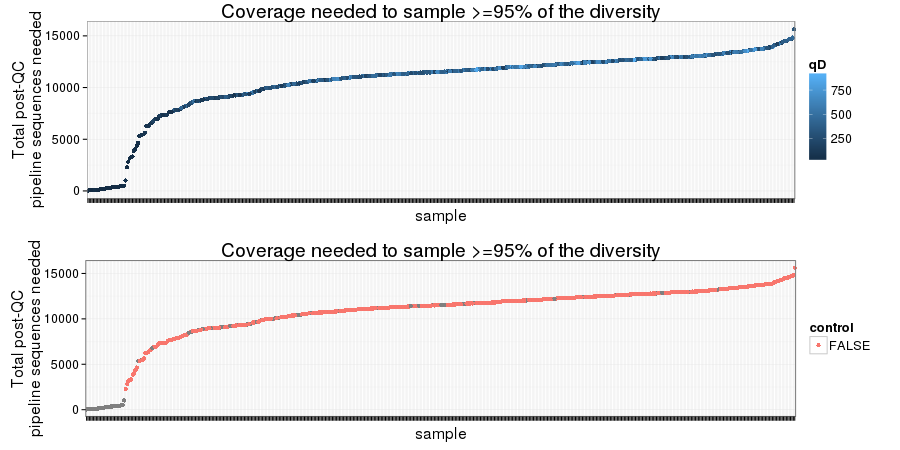

In [136]:
%%R -w 900 -h 450

tbl.iNEXT.res.fm$sample = reorder(tbl.iNEXT.res.fm$sample, tbl.iNEXT.res.fm$first.m)

tbl.iNEXT.res.fm.f = tbl.iNEXT.res.fm %>%
    filter(order == 1)

# plotting 
p1 = ggplot(tbl.iNEXT.res.fm.f, aes(sample, first.m, color=qD)) +
    geom_point() +
    labs(y = 'Total post-QC\npipeline sequences needed',
         title = 'Coverage needed to sample >=95% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank(),
        plot.margin = unit(c(0, 1.2, 0, 0.3), 'cm')
        )

p2 = ggplot(tbl.iNEXT.res.fm.f, aes(sample, first.m, color=control)) +
    geom_point() +
    labs(y = 'Total post-QC\npipeline sequences needed',
         title = 'Coverage needed to sample >=95% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

grid.arrange(p1, p2, ncol=1)

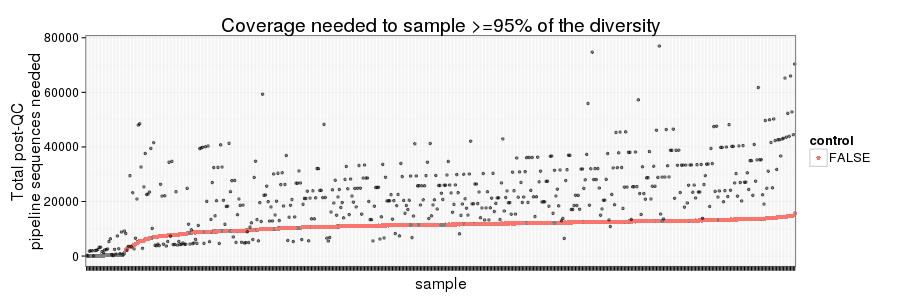

In [137]:
%%R -w 900 -h 300


ggplot(tbl.iNEXT.res.fm.f, aes(sample, first.m, color=control)) +
    geom_point() +
    geom_point(aes(y=m.obs), shape=20, color='black', alpha=0.5) +
    labs(y = 'Total post-QC\npipeline sequences needed',
         title = 'Coverage needed to sample >=95% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

#### Notes

* black circles = number of observed OTUs

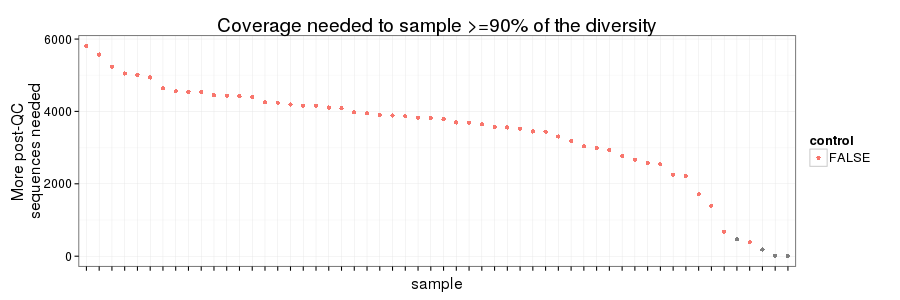

In [138]:
%%R -w 900 -h 300

tbl.iNEXT.res.d = tbl.iNEXT.res.fm %>%
    mutate(extra_needed = ifelse(first.m - m.obs > 0, first.m - m.obs, 0)) %>%#, 
          # microcosm_rep = ifelse(is.na(microcosm_rep), 1, microcosm_rep)) %>%
    filter(extra_needed > 0)

tbl.iNEXT.res.d$sample = reorder(tbl.iNEXT.res.d$sample, -tbl.iNEXT.res.d$extra_needed)

ggplot(tbl.iNEXT.res.d, aes(sample, extra_needed, color=control)) +
    geom_point() +
    labs(y = 'More post-QC\nsequences needed',
         title = 'Coverage needed to sample >=90% of the diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank() #element_text(angle=45, hjust=1, vjust=1)
        )

In [139]:
%%R
cat('Number of samples where more coverage is needed: ',
     tbl.iNEXT.res.d$sample %>% as.vector %>% unique %>% length, '\n')

Number of samples where more coverage is needed:  56 


In [140]:
%%R
cat('#Samples_to_resequence\n')
paste(tbl.iNEXT.res.d$sample %>% as.vector %>% sort, collapse='\n') %>% cat

#Samples_to_resequence
12C.NTH.D30.R4.Frac12
12C.NTH.D30.R4.Frac13
12C.NTH.D30.R4.Frac16
12C.NTH.D30.R4.Frac17
12C.NTH.D30.R4.Frac4
12C.NTH.D30.R4.Frac5
12C.NTH.D30.R4.Frac8
12C.NTH.D30.R4.Frac9
12C.NTH.D7.R4.Frac14
12C.NTH.D7.R4.Frac17
12C.NTH.D7.R4.Frac25
12C.NTH.D7.R4.Frac26
12C.PTH.D3.R4.Frac24
12C.PTH.D3.R4.Frac26
12C.PTH.D3.R4.Frac28
12C.PTH.D3.R4.H2O
13C.NTH.D3.R4.F23
13C.PTH.D30.R4.Frac14
13C.PTH.D30.R4.Frac17
13C.PTH.D30.R4.Frac22
13C.PTH.D30.R4.Frac26
13C.PTH.D30.R4.Frac6
13C.PTH.D30.R4.Frac9
13C.PTH.D3.R4.Frac15
13C.PTH.D3.R4.Frac23
13C.PTH.D3.R4.Frac25
13C.PTH.D3.R4.Frac27
13C.PTH.D3.R4.Frac7
13C.PTH.D3.R4.H2O
13X.NTH.D14.R4.Frac14
13X.NTH.D14.R4.Frac16
13X.NTH.D14.R4.Frac28
13X.NTH.D14.R4.Frac6
13X.NTH.D7.R4.Frac10
13X.NTH.D7.R4.Frac13
13X.NTH.D7.R4.Frac14
13X.NTH.D7.R4.Frac16
13X.NTH.D7.R4.Frac17
13X.NTH.D7.R4.Frac18
13X.NTH.D7.R4.Frac22
13X.NTH.D7.R4.Frac26
13X.NTH.D7.R4.Frac27
13X.NTH.D7.R4.Frac6
13X.NTH.D7.R4.Frac9
13X.PTH.D14.R4.Frac14
13X.PTH.D14.R4.Frac16
13X.PTH.D1

In [141]:
%%R
filter(sample.data, Full.sample %in% tbl.iNEXT.res.d$sample) %>%
select(Full.sample, Barcode, Pool)

             Full.sample Barcode Pool
1   12C.PTH.D3.R4.Frac24       3    2
2   12C.PTH.D3.R4.Frac26       5    2
3   12C.PTH.D3.R4.Frac28       7    2
4      12C.PTH.D3.R4.H2O       8    2
5   13X.PTH.D14.R4.Frac8      11    2
6  13X.PTH.D14.R4.Frac14      17    2
7  13X.PTH.D14.R4.Frac16      19    2
8  13X.PTH.D14.R4.Frac28      31    2
9     13X.PTH.D14.R4.H2O      32    2
10   13C.PTH.D3.R4.Frac7      35    2
11  13C.PTH.D3.R4.Frac15      43    2
12  13C.PTH.D3.R4.Frac23      51    2
13  13C.PTH.D3.R4.Frac25      53    2
14  13C.PTH.D3.R4.Frac27      55    2
15     13C.PTH.D3.R4.H2O      57    2
16   13X.PTH.D1.R4.Frac7      59    2
17   13X.PTH.D1.R4.Frac9      61    2
18  13X.PTH.D1.R4.Frac11      63    2
19  13X.PTH.D1.R4.Frac12      64    2
20  13X.PTH.D1.R4.Frac14      66    2
21  13X.PTH.D1.R4.Frac18      70    2
22  13X.PTH.D1.R4.Frac19      71    2
23  13X.NTH.D14.R4.Frac6      83    2
24 13X.NTH.D14.R4.Frac14      91    2
25 13X.NTH.D14.R4.Frac16      93    2
26 13X.NTH.D

## Finding sampling depth needed for a specific coverage

In [30]:
%%R
tbl = do.call(rbind, out$iNextEst)
tbl$sample = gsub('\\.[0-9]+$','', rownames(tbl))
tbl %>% head

    m       method order    qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1.1 1 interpolated     0 1.000     1.000     1.000 0.222     0.106     0.339
1.2 1 interpolated     0 1.000     1.000     1.000 0.222     0.106     0.339
1.3 2 interpolated     0 1.778     1.661     1.894 0.392     0.239     0.545
1.4 3 interpolated     0 2.386     2.118     2.654 0.521     0.361     0.680
1.5 4 interpolated     0 2.865     2.443     3.288 0.619     0.461     0.776
1.6 5 interpolated     0 3.247     2.676     3.818 0.693     0.540     0.846
    sample
1.1      1
1.2      1
1.3      1
1.4      1
1.5      1
1.6      1


In [34]:
%%R
tbl %>% filter(sample == 1) %>% arrange(m)

     m       method order    qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1    1 interpolated     0 1.000     1.000     1.000 0.222     0.106     0.339
2    1 interpolated     0 1.000     1.000     1.000 0.222     0.106     0.339
3    1 interpolated     1 1.000     1.000     1.000 0.222     0.119     0.326
4    1 interpolated     1 1.000     1.000     1.000 0.222     0.119     0.326
5    1 interpolated     2 1.000     1.000     1.000 0.222     0.115     0.330
6    1 interpolated     2 1.000     1.000     1.000 0.222     0.115     0.330
7    2 interpolated     0 1.778     1.661     1.894 0.392     0.239     0.545
8    2 interpolated     1 1.714     1.595     1.834 0.392     0.257     0.527
9    2 interpolated     2 1.636     1.503     1.770 0.392     0.248     0.535
10   3 interpolated     0 2.386     2.118     2.654 0.521     0.361     0.680
11   3 interpolated     1 2.238     1.977     2.499 0.521     0.386     0.655
12   3 interpolated     2 2.077     1.803     2.351 0.521     0.

In [33]:
%%R
# for each sample: first m where sequence coverage is > 90% 
tbl.s = tbl %>% 
    filter(SC >= 0.9) %>%
    group_by(order, sample) %>%
    mutate(first_m = first(m))
    #summarize(first_m = first(m))
tbl.s

Source: local data frame [1,641 x 11]
Groups: order, sample

    m       method order    qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1  12 interpolated     0 4.559     3.171     5.946 0.905     0.793     1.017
2  13 interpolated     0 4.654     3.176     6.131 0.916     0.807     1.024
3  14 interpolated     0 4.738     3.175     6.300 0.924     0.817     1.031
4  15 interpolated     0 4.814     3.170     6.457 0.931     0.825     1.038
5  16 interpolated     0 4.882     3.162     6.603 0.938     0.831     1.045
6  17 interpolated     0 4.944     3.149     6.740 0.944     0.835     1.054
7  18     observed     0 5.000     3.131     6.869 0.950     0.840     1.061
8  19 extrapolated     0 5.050     3.104     6.996 0.956     0.852     1.059
9  19 extrapolated     0 5.050     3.104     6.996 0.956     0.852     1.059
10 20 extrapolated     0 5.094     3.075     7.114 0.960     0.862     1.058
.. ..          ...   ...   ...       ...       ...   ...       ...       ...
Variables not s

In [32]:
%%R
tbl.j = inner_join(tbl, tbl.s, c('sample' = 'sample',
                                 'order' = 'order',
                                 'm' = 'first_m'))
tbl.j %>% head

   m       method order    qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1 12 interpolated     0 4.559     3.171     5.946 0.905     0.793     1.017
2 12 interpolated     1 3.918     2.998     4.837 0.905     0.814     0.997
3 12 interpolated     2 3.484     2.515     4.453 0.905     0.812     0.998
4 23 interpolated     0 9.486     8.514    10.457 0.919     0.884     0.955
5 23 interpolated     1 8.534     7.526     9.542 0.919     0.895     0.943
6 23 interpolated     2 7.818     6.608     9.028 0.919     0.884     0.954
  sample
1      1
2      1
3      1
4      2
5      2
6      2


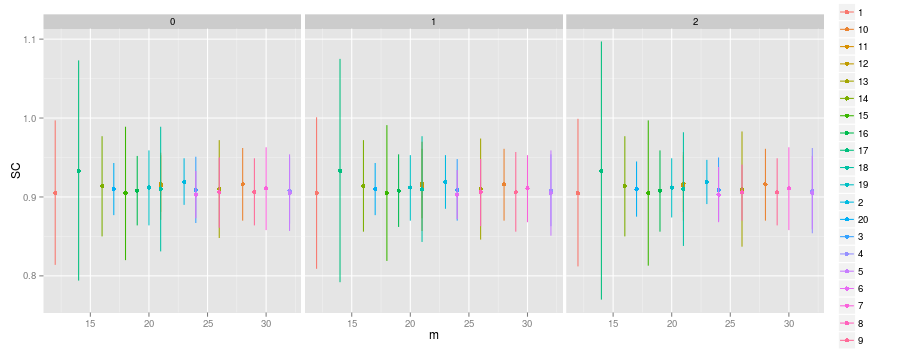

In [93]:
%%R -w 900 -h 350
# 
ggplot(tbl.j, aes(m, SC, ymin=SC.95.LCL, ymax=SC.95.UCL, color=sample)) +
    geom_pointrange() +
    facet_grid(. ~ order)

In [63]:
%%R
# max m for extrapolates
tbl.s = tbl %>% 
    filter(method == 'extrapolated') %>%
    group_by(order, method) %>%
    summarize(max_m = max(m))
tbl.s %>% as.data.frame %>% head

  order       method max_m
1     0 extrapolated    96
2     1 extrapolated    96
3     2 extrapolated    96


In [64]:
%%R

# SC for max_m
tbl.j = inner_join(tbl, tbl.s, c('order' = 'order',
                                 'method' = 'method',
                                 'm' = 'max_m'))
tbl.j

   m       method order     qD qD.95.LCL qD.95.UCL SC SC.95.LCL SC.95.UCL
1 96 extrapolated     0 11.000     9.314    12.686  1     0.985     1.015
2 96 extrapolated     1 11.646    10.479    12.813  1     0.991     1.009
3 96 extrapolated     2 11.080     9.365    12.795  1     0.994     1.006
  treatment
1         6
2         6
3         6


***

In [13]:
%%R -w 800
data(spider)
spider %>% head 

$Girdled
 [1] 46 22 17 15 15  9  8  6  6  4  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1
[26]  1

$Logged
 [1] 88 22 16 15 13 10  8  8  7  7  7  5  4  4  4  3  3  3  3  2  2  2  2  1  1
[26]  1  1  1  1  1  1  1  1  1  1  1  1



In [14]:
%%R
out <- iNEXT(spider, q=c(0, 1, 2), datatype="abundance", endpoint=500)
out %>% head

$DataInfo
          n S.obs  C.hat f1 f2 f3 f4 f5 f6 f7 f8 f9 f10
Girdled 168    26 0.9289 12  4  0  1  0  2  0  1  1   0
Logged  252    37 0.9446 14  4  4  3  1  0  3  2  0   1

$iNextEst
$iNextEst$Girdled
      m       method order     qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1     1 interpolated     0  1.000     1.000     1.000 0.122     0.098     0.147
2    10 interpolated     0  6.479     6.084     6.874 0.597     0.547     0.647
3    19 interpolated     0  9.450     8.658    10.243 0.738     0.690     0.786
4    28 interpolated     0 11.514    10.356    12.673 0.803     0.760     0.847
5    37 interpolated     0 13.127    11.636    14.618 0.839     0.798     0.879
6    47 interpolated     0 14.622    12.793    16.452 0.862     0.824     0.900
7    56 interpolated     0 15.803    13.687    17.918 0.876     0.840     0.912
8    65 interpolated     0 16.877    14.489    19.265 0.886     0.851     0.921
9    74 interpolated     0 17.874    15.225    20.523 0.893     0.859    

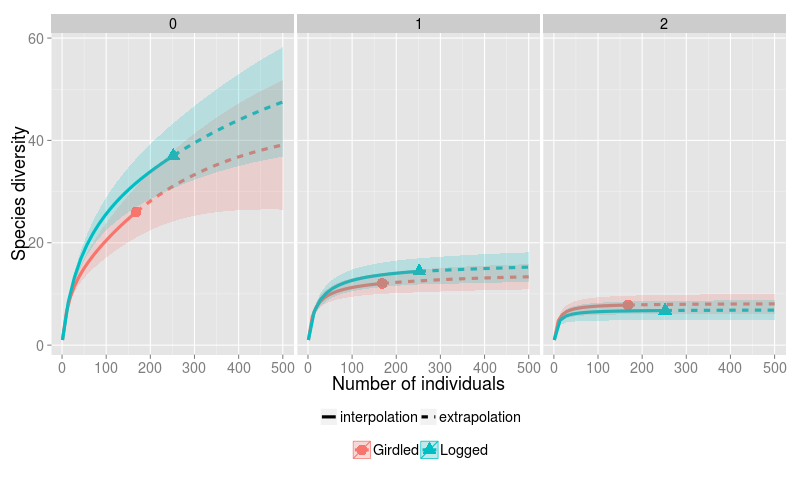

In [16]:
%%R -w 800
ggiNEXT(out, type=1, facet.var="order", color.var="site")

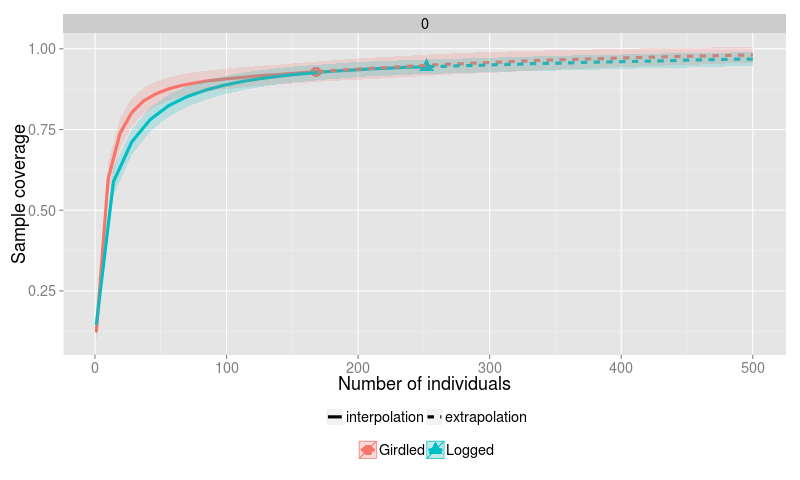

In [41]:
%%R -w 800
ggiNEXT(out, type=2, facet.var="order", color.var="site")

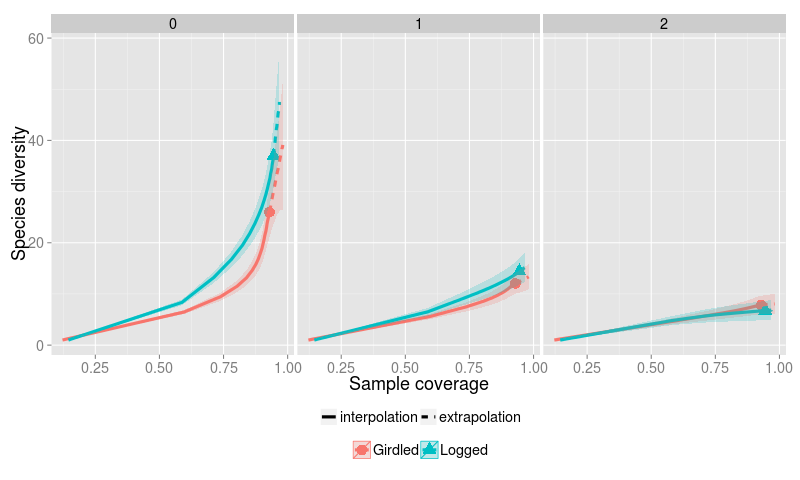

In [20]:
%%R -w 800
ggiNEXT(out, type=3, facet.var="order", color.var="site")

In [23]:
%%R

tbl = do.call(rbind, out$iNextEst)
tbl$treatment = gsub('\\.[0-9]+$','', rownames(tbl))
tbl %>% head

           m       method order     qD qD.95.LCL qD.95.UCL    SC SC.95.LCL
Girdled.1  1 interpolated     0  1.000     1.000     1.000 0.122     0.098
Girdled.2 10 interpolated     0  6.479     6.084     6.874 0.597     0.547
Girdled.3 19 interpolated     0  9.450     8.658    10.243 0.738     0.690
Girdled.4 28 interpolated     0 11.514    10.356    12.673 0.803     0.760
Girdled.5 37 interpolated     0 13.127    11.636    14.618 0.839     0.798
Girdled.6 47 interpolated     0 14.622    12.793    16.452 0.862     0.824
          SC.95.UCL treatment
Girdled.1     0.147   Girdled
Girdled.2     0.647   Girdled
Girdled.3     0.786   Girdled
Girdled.4     0.847   Girdled
Girdled.5     0.879   Girdled
Girdled.6     0.900   Girdled


In [36]:
%%R
# summarizing max sample coverage
tbl.s = tbl %>% 
    group_by(treatment, method, order) %>%
    summarize(max_SC = max(SC)) 
tbl.s

tbl.j = inner_join(tbl, tbl.s, c('treatment' = 'treatment',
                                 'method' = 'method',
                                 'order' = 'order',
                                 'SC' = 'max_SC'))
tbl.j %>% head(n=3)

    m       method order     qD qD.95.LCL qD.95.UCL    SC SC.95.LCL SC.95.UCL
1 167 interpolated     0 25.929    20.980    30.877 0.929     0.897     0.960
2 168     observed     0 26.000    21.029    30.971 0.929     0.897     0.960
3 500 extrapolated     0 39.126    26.499    51.753 0.981     0.957     1.005
  treatment
1   Girdled
2   Girdled
3   Girdled


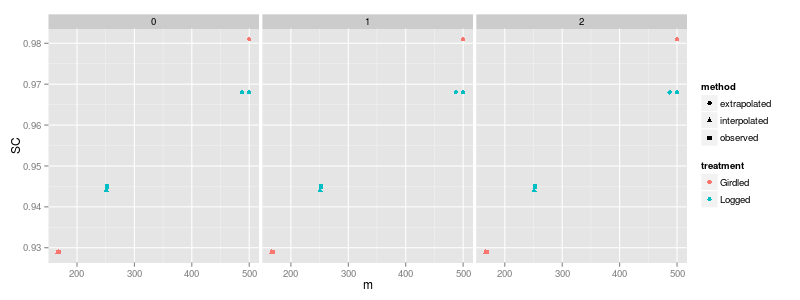

In [40]:
%%R -w 800 -h 300
ggplot(tbl.j, aes(m, SC, color=treatment, shape=method)) +
    geom_point() +
    facet_grid(. ~ order)